# Prompt 
* HW assignment: Using dataset selected for final project:


* Perform feature engineering
* Estimate baseline model
* Estimate different model and/or different loss function to improve model performance
* Hint: Determine what metric(s) is/are appropriate for your use case
* Interpret results
* Explain what you did and why

## Write-up
* Goal: Forecast the last 6 weeks of the time series for each store.
* Kaggle Prompt: Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

**Variable Importance**

I first utilize a GBM in order to see if it can quickly tell me which variables are important or not. I do not set this up as a normal time series forecasting question, so I don't add any lags (prev day, week, month). I also don't split the dataset by time series and I don't force the train/test to not overlap. However, using the output, I am able to see that the following variables are important: 

    1. "Open": if store is open
    2. "Promo": if that Day is a promo day
    3. "CompetitionDistance": nearest competitor distance
    
**Feature Engineering**

I honestly couldn't think of a ton of different features to add. I did think that adding in that day's distance to the previous open day and the previous promo day could be promising, given how important those features seemed to be.

**1st Attempt: Prophet w/o addtl regressors**
As a baseline model, I decided to use <a href="https://research.fb.com/prophet-forecasting-at-scale/">Prophet from fb</a>. It's a time series model that I use as a baseline model because it doesn't make a ton of assumptions about the underlying data structure.

**2nd Attempt: Prophet w/ addtl regressors**
Additionally, it is very simple to implement and has the ability to add in additional regressors. The second version of the model included the regressors for the top 3 important variables as well as some of the features that I created, "daydiff_open_dt" and "daydiff_promo_dt". These variables represent the distance from the date being forecast to the previous day the store was open as well as the previous day that the store had a promo.

**Metric Selection**
The competition utilizes RMSPE (Root Mean Squared Percentage Error) and doesn't include any day with 0 sales. I think that this is good in that it penalizes large errors. However, I do not like the fact that we are looking at the error relative to the prediction, so I also recommend looking at RMSE (without 0 sale days). Since the competition says the purpose is to help the managers effectively staff their stores, I make the assumption that there are a certain number of salespeople per sales volume. The problem with RMSPE is: if there were only 1 store/day and we forecast 50,000 in sales and the actual came in at 100,000, the RMSPE would be 50%. Now, if there were only 1 store/day and we forecast 50 in sales and the actual came in at 100, the RMSPE would **also** be 50%. To me, the first seems like a much bigger error in terms of staffing (if there is some $/salespeople ratio). RMSE for the first scenario is 50,000 and 50 for the second.

**Interpreting Results**
Manually looking at some of the forecast graphs, the model looks like it does a pretty good job of picking up on Day of Week Seasonality. Because of the granularity of the data, I will need to dig further into how to interpret results at the store-level.

### Import Packages and Data

In [25]:
from multiprocessing import Pool, cpu_count

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [26]:
pwd

'/Users/andrewsang/Documents/ucla_stats'

In [27]:
# cd /home/paperspace/ANDREW-MINKYU-SANG/

In [28]:
cd /Users/andrewsang/Documents/ucla_stats/

/Users/andrewsang/Documents/ucla_stats


In [29]:
ls

Class0-Intro/     Class3/           Class6/           final_proj/
Class1/           Class4/           Class7/           req.txt
Class2/           Class5/           README.md         requirements.txt


In [30]:
%%timeit 

train = pd.read_csv('final_proj/input_data/train.csv')

/Users/andrewsang/anaconda3/envs/stat404-final/lib/python3.6/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)
/Users/andrewsang/anaconda3/envs/stat404-final/lib/python3.6/site-packages/IPython/core/magics/execution.py:1135: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  all_runs = timer.repeat(repeat, number)


1.48 s ± 60.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%%timeit

typ_dict = {'Store':np.int8,
 'DayOfWeek':np.int8,
 'Date':object,
 'Sales':np.int8,
 'Customers':np.int8,
 'Open':np.int8,
 'Promo':np.int8,
 'StateHoliday':object,
 'SchoolHoliday':np.int8}

train = pd.read_csv('final_proj/input_data/train.csv',dtype=typ_dict)

1.22 s ± 66.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Adding in the dictionary sped up the data load process. I did this because it seemed like something that would speed up the process. In a section below, I utilized multiprocessing in order to speed up a for-loop that I had been running.

In [32]:
train = pd.read_csv('final_proj/input_data/train.csv')
test = pd.read_csv('final_proj/input_data/test.csv')
store = pd.read_csv('final_proj/input_data/store.csv')

In [33]:
# train.loc[:,'Date'] = pd.to_datetime(train['Date'])
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


### Functions for Data Manipulation and Feature Engineering

In [34]:
def data_manipulation(dataframe):
    dataframe = dataframe.merge(store,how='left',on='Store')
    mask = pd.isnull(dataframe['CompetitionDistance'])
    # replace 3 stores with median where competition distance is null
    dataframe.loc[mask,'CompetitionDistance'] = store['CompetitionDistance'].median() 
    return dataframe

In [35]:
def day_dist(dataframe, start_dt):
    # measuring current date - 
    dataframe = dataframe.sort_values(['Store','Date'])
    dataframe.loc[:,'prev_'+start_dt] = dataframe.groupby('Store')[start_dt] \
                                                 .transform(lambda x:x.ffill().shift(1))
    dataframe.loc[:,'daydiff_'+start_dt] = (dataframe['Date']- dataframe['prev_'+start_dt]) / \
                                            np.timedelta64(1, 'D') - 1
    dataframe.loc[pd.isnull(dataframe['daydiff_'+start_dt]),'daydiff_'+start_dt] = np.NaN
    return dataframe

def ftr_eng(dataframe):
    dataframe.loc[:,'promo_dt'] = np.where(dataframe['Promo']==1,dataframe['Date'], np.NaN)
    dataframe.loc[:,'closed_dt'] = np.where(dataframe['Open']==0,dataframe['Date'], np.NaN)
    dataframe.loc[:,'open_dt'] = np.where(dataframe['Open']==1,dataframe['Date'], np.NaN)
    dataframe.head()
    for k in ['Date','closed_dt','open_dt','promo_dt']:
        dataframe.loc[:,k] = pd.to_datetime(dataframe.loc[:,k])
        
    dataframe = day_dist(dataframe,'open_dt') # distance to most recent open day
    dataframe = day_dist(dataframe,'promo_dt') # distance to most recent promo day
    return dataframe

In [36]:
def piv_df(dataframe):
    return pd.pivot_table(dataframe,values='Sales',index=['Store'], columns=['Date']).reset_index()

## Use GBM for Variable Importance

In [37]:
df = pd.read_csv('final_proj/input_data/train.csv')
df = data_manipulation(df)
df = ftr_eng(df)

In [38]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

h2o.init()

hf = h2o.H2OFrame(df)

# Set up X and Y columns
X = [e for e in df]
X.remove('Store')
X.remove('Sales')
X.remove('Customers')
X.remove('open_dt')
X.remove('closed_dt')
X.remove('promo_dt')
y = 'Customers'

# Split Frame
htrain, hvalid, htest = hf.split_frame([0.6, 0.2], seed=1234)

# Specify Model
gbm = H2OGradientBoostingEstimator(seed=123)
gbm.train(X, y, training_frame=htrain, validation_frame=hvalid)

# Summary
gbm

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,11 hours 2 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_andrewsang_thu7yj
H2O cluster total nodes:,1
H2O cluster free memory:,1.394 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551600840383_3


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 57928.536249655896
RMSE: 240.68347730921602
MAE: 159.0505944959152
RMSLE: NaN
Mean Residual Deviance: 57928.536249655896

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 57898.3822481926
RMSE: 240.62082671330137
MAE: 159.0585307656475
RMSLE: NaN
Mean Residual Deviance: 57898.3822481926
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-03 11:17:44,0.006 sec,0.0,463.8546776,323.3367117,215161.1619753,464.9231354,324.2250935,216153.5218287
,2019-03-03 11:17:44,0.664 sec,1.0,436.0642002,305.5471292,190151.9866878,437.0420477,306.3570512,191005.7514948
,2019-03-03 11:17:45,1.127 sec,2.0,411.8767929,290.4116649,169642.4925304,412.7832065,291.1060681,170389.9755470
,2019-03-03 11:17:45,1.643 sec,3.0,390.6172189,276.4536507,152581.8116886,391.4412562,277.0587430,153226.2570711
,2019-03-03 11:17:46,2.624 sec,4.0,372.4137950,264.6136366,138692.0346852,373.1707346,265.1325808,139256.3971525
,2019-03-03 11:17:47,2.997 sec,5.0,357.2776961,253.9781465,127647.3521321,357.9672499,254.4377650,128140.5520265
,2019-03-03 11:17:47,3.405 sec,6.0,344.1358551,244.7280679,118429.4867558,344.7514164,245.1404617,118853.5390907
,2019-03-03 11:17:48,3.891 sec,7.0,332.4251266,236.5681555,110506.4648210,332.9715818,236.9225886,110870.0742836
,2019-03-03 11:17:52,8.095 sec,19.0,274.4368776,186.3131779,75315.5998115,274.4445947,186.3975064,75319.8355366
,2019-03-03 11:17:56,12.264 sec,29.0,261.4773740,172.1214485,68370.4171190,261.3917615,172.1797297,68325.6529917


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Open,262888194048.0000000,1.0,0.5202336
StoreType,98389573632.0000000,0.3742639,0.1947047
CompetitionDistance,59204247552.0000000,0.2252069,0.1171602
Promo2SinceWeek,19558504448.0000000,0.0743986,0.0387046
Promo,14952274944.0000000,0.0568769,0.0295893
CompetitionOpenSinceYear,10641412096.0000000,0.0404789,0.0210585
Promo2SinceYear,9724909568.0000000,0.0369926,0.0192448
CompetitionOpenSinceMonth,9576714240.0000000,0.0364288,0.0189515
Assortment,7115262976.0000000,0.0270657,0.0140805
DayOfWeek,5457713664.0000000,0.0207606,0.0108004


## Prophet

In [39]:
def prophetFormat(dataframe):
    dataframe = dataframe.rename(index=str, columns={"Sales": "y","Date": "ds"})
    dataframe.loc[:,'ds'] = pd.to_datetime(dataframe['ds'])
    for c in ['Promo','Open','CompetitionDistance']:
        dataframe.loc[:,c] = dataframe.loc[:,c].astype(float)
    dataframe.loc[:,'floor'] = 0
    dataframe = dataframe.fillna(0)
    return dataframe

In [40]:
from fbprophet import Prophet

og = pd.read_csv('final_proj/input_data/train.csv')
og = data_manipulation(og)
og = ftr_eng(og)
og = prophetFormat(og)

date_change = pd.to_datetime('2015-06-20') # this date leaves 42 days post
mask = og['ds']>=date_change
fbtest = og[mask]
fbtrain = og[mask==False]

In [53]:
store_list = fbtrain['Store'].unique().tolist()

def run_indiv_forecast(idx, addtl_reg=False,return_model=False):
    # pull data
    fbsample = fbtrain.loc[fbtrain['Store']==store_list[idx],:]
    fbtest_sample = fbtest.loc[fbtest['Store']==store_list[idx],:]
    
    # create model, add regressors
    m = Prophet(daily_seasonality=False)
    if addtl_reg:
        m.add_regressor('Promo',mode='multiplicative')
        m.add_regressor('Open',mode='multiplicative')
        m.add_regressor('CompetitionDistance')
        m.add_regressor('daydiff_open_dt')
        m.add_regressor('daydiff_promo_dt')
    m.fit(fbsample)
    
    # create results, merge w actuals
    forecast = m.predict(fbtest_sample)
    forecast.loc[:,'Store'] = fbtrain.loc[fbtrain['Store']==store_list[idx],'Store'].max()
    fc = forecast[['Store','ds','yhat']]
    fc = fc.merge(fbtest_sample.loc[:,['ds','y']],how='left',on=['ds'])
    if return_model:
        return forecast, m
    return fc

def run_individ_forecast_w_reg(idx):
    return run_indiv_forecast(idx,addtl_reg=True)

def run_individ_forecast_w_reg_mod(idx):
    return run_indiv_forecast(idx,addtl_reg=True,return_model=True)

### 1st Attempt: Prophet w/o addtl regressors

Parallelization comes in spirit from: https://medium.com/devschile/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245

In [ ]:
# # Takes a long time to run

# import time

# # Run Version without External Regressors
# store_list = train.Store.unique()
# start_time = time.time()

# p = Pool(cpu_count())
# seriesidx = np.arange(0,train['Store'].nunique())
# predictions = list(p.imap(run_indiv_forecast, seriesidx))
# p.close()
# p.join()

# print("-- %s seconds --" % (time.time() - start_time))

# results = pd.DataFrame()

# for e in np.arange(0,len(predictions)):
#     results = pd.concat([results,predictions[e]])

In [42]:
# Output results to csv
# results.to_csv('final_proj/workprod/results.csv')

# Load in results via csv
results = pd.read_csv('final_proj/workprod/results.csv')
results = results.iloc[:,1:]

In [43]:
results.head()

,Store,ds,yhat,y
0,1,2015-06-20,4680.464,4097
1,1,2015-06-21,-305.641,0
2,1,2015-06-22,4637.539,3846
3,1,2015-06-23,4334.884,3762
4,1,2015-06-24,4131.795,3346


In [221]:
# Create Evaluation Metrics
def rmse(dataframe):
    interim = dataframe.loc[dataframe['y']!=0,:]
    return np.sqrt(np.mean((interim['y'] - interim['yhat'])**2))

def rmspe(dataframe):
    interim = dataframe.loc[dataframe['y']!=0,:]
    return np.sqrt(np.mean(((interim['y']-interim['yhat'])/interim['y'])**2))

In [222]:
print('rmse is '+str(rmse(results)))
print('rmspe is '+str(rmspe(results)))

rmse is 1630.6173456447284
rmspe is 0.2315527978917023


### 2nd Attempt: Prophet w/ addtl regressors

In [46]:
# # Takes a while to run

# # Run Version with External Regressors
# store_list = train.Store.unique()
# results2 = pd.DataFrame()

# start_time = time.time()

# p = Pool(cpu_count())
# seriesidx = np.arange(0,train['Store'].nunique())
# predictions = list(p.imap(run_individ_forecast_w_reg, seriesidx))
# p.close()
# p.join()

# print("--- %s seconds ---" % (time.time() - start_time))

# results2 = pd.DataFrame()

# for e in np.arange(0,len(predictions)):
#     results2 = pd.concat([results2,predictions[e]])

In [47]:
# Output second version of the model to csv
# results.to_csv('final_proj/workprod/results2.csv')

# Load in results via csv
results2 = pd.read_csv('final_proj/workprod/results2.csv')
results2 = results2.iloc[:,1:]

In [48]:
results2.head()

,Store,ds,yhat,y
0,1,2015-06-20,4776.374,4097
1,1,2015-06-21,-216.658,0
2,1,2015-06-22,4755.756,3846
3,1,2015-06-23,4223.436,3762
4,1,2015-06-24,4036.238,3346


In [49]:
diff = results.groupby('Store').sum().reset_index()
diff.loc[:,'err'] = diff['y'] - diff['yhat']
diff.sort_values('err',ascending=False).head()

,Store,yhat,y,err
347,348,129479.055,327452,197972.945
99,100,213276.239,295294,82017.761
1020,1021,271772.711,344760,72987.289
386,387,263225.258,334818,71592.742
56,57,255539.824,313405,57865.176


In [225]:
diff2 = results2.copy()
diff2.loc[:,'err'] = diff2['y'] - diff2['yhat']
diff2.sort_values('err',ascending=False).head()

,Store,ds,yhat,y,err
38138,909,2015-06-22,11678.124,41551,29872.876
12231,292,2015-06-29,8715.012,29161,20445.988
38139,909,2015-06-23,10844.066,30038,19193.934
36766,876,2015-07-06,10041.619,27330,17288.381
12232,292,2015-06-30,7497.019,23584,16086.981


In [223]:
print('rmse is '+str(rmse(results2)))
print('rmspe is '+str(rmspe(results2)))

# Slight improvement in rmse & rmspe

rmse is 1601.6889262847199
rmspe is 0.21327051770936847


### Looking at Results

/Users/andrewsang/anaconda3/envs/stat404-final/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


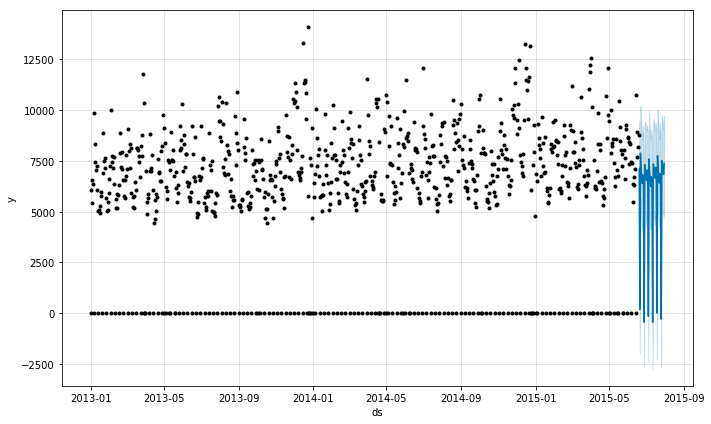

In [54]:
# Components

forecast, m = run_individ_forecast_w_reg_mod(100)
fig1 = m.plot(forecast)

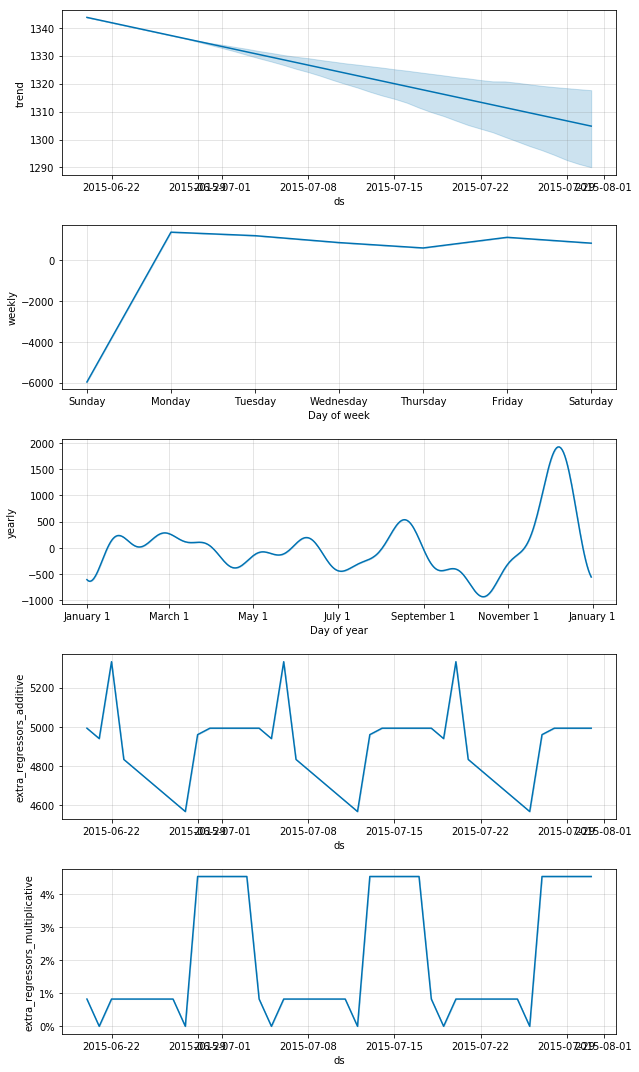

In [55]:
fig2 = m.plot_components(forecast)

In [61]:
combo = results.merge(results2,how='left',on=['Store','ds'],suffixes=('_1', '_2'))
combo.loc[:,'ds'] = pd.to_datetime(combo['ds'])
combo = combo.merge(fbtest,how='left',on=['Store','ds'],suffixes=('_pred','_test'))

In [65]:
combo.loc[:,'err_1'] = combo['y_1'] - combo['yhat_1']
combo.loc[:,'err_2'] = combo['y_2'] - combo['yhat_2']
combo.head(1).T

,0
Store,1
ds,2015-06-20 00:00:00
yhat_1,4680.464
y_1,4097
yhat_2,4776.374
y_2,4097
DayOfWeek,6
y,4097
Customers,494
Open,1.000


In [66]:
combo.loc[combo['y']!=0,['err_1','err_2']].median()

err_1   -241.426
err_2     67.280
dtype: float64

In [67]:
combo.loc[combo['y']!=0,:].groupby('DayOfWeek')['err_1','err_2'].describe().T

DayOfWeek            1         2         3         4         5         6  \
err_1 count   6682.000  6682.000  6682.000  6680.000  6681.000  6682.000   
      mean     132.991    40.918   -38.356   283.695    -3.545  -549.859   
      std     2253.367  2107.555  1407.394  1204.541  1413.766   800.697   
      min    -7289.853 -6103.837 -6812.589 -4024.207 -4704.684 -7532.214   
      25%    -1612.175 -1534.818 -1067.616  -581.394  -950.509  -912.715   
      50%       14.019  -305.673  -109.106   183.880  -279.288  -484.187   
      75%     1783.171  1295.780   906.325  1079.065   834.254  -119.640   
      max    29792.642 19135.802 10112.283  9124.165 10371.754 13780.387   
err_2 count   6682.000  6682.000  6682.000  6680.000  6681.000  6682.000   
      mean     372.721   451.835   278.080   485.007   301.627  -168.061   
      std     2244.547  1865.172  1290.156  1218.674  1393.852  1014.302   
      min   -11983.144 -5534.024 -6644.701 -3810.350 -5032.606 -7224.394   
      25%    -1029.765  -720.581  -537.674  -321.782  -512.599  -684.495   
      50%      -31.844     1.921   144.779   317.472   116.501  -147.605   
      75%     1689.039  1410.508   965.294  1166.393   975.192   393.488   
      max    29872.876 19193.934 11885.434  9872.605 10523.878 13798.241   

DayOfWeek           7  
err_1 count   193.000  
      mean    586.903  
      std     979.604  
      min   -1882.441  
      25%       3.639  
      50%     469.255  
      75%     945.506  
      max    4902.750  
err_2 count   193.000  
      mean    695.450  
      std    1200.569  
      min   -2806.309  
      25%      79.508  
      50%     673.704  
      75%    1199.388  
      max    5540.947

In [68]:
combo.loc[combo['y']!=0,:].groupby('Promo')['err_1','err_2'].describe().T

Promo            0.000     1.000
err_1 count  23581.000 16701.000
      mean    -981.205  1338.486
      std     1022.659  1336.321
      min    -7532.214 -6812.589
      25%    -1515.221   492.176
      50%     -888.769  1121.951
      75%     -375.038  1938.441
      max    29792.642 21892.607
err_2 count  23581.000 16701.000
      mean    -333.709  1167.790
      std     1123.291  1698.629
      min   -11983.144 -6644.701
      25%     -870.533    11.093
      50%     -269.102  1014.913
      75%      263.760  2124.247
      max    29872.876 20445.988

In [69]:
combo.loc[combo['err_2']<-20000,:]

,Store,ds,yhat_1,y_1,yhat_2,y_2,DayOfWeek,y,Customers,Open,...,promo_dt,closed_dt,open_dt,prev_open_dt,daydiff_open_dt,prev_promo_dt,daydiff_promo_dt,floor,err_1,err_2
36787,876,2015-07-27,11920.088,0,23341.847,0,1,0,0,0.000,...,2015-07-27 00:00:00,2015-07-27 00:00:00,0,2015-07-15 00:00:00,11.000,2015-07-17 00:00:00,9.000,0,-11920.088,-23341.847
36788,876,2015-07-28,11967.497,0,26830.453,0,2,0,0,0.000,...,2015-07-28 00:00:00,2015-07-28 00:00:00,0,2015-07-15 00:00:00,12.000,2015-07-27 00:00:00,0.000,0,-11967.497,-26830.453
36789,876,2015-07-29,9469.539,0,25880.382,0,3,0,0,0.000,...,2015-07-29 00:00:00,2015-07-29 00:00:00,0,2015-07-15 00:00:00,13.000,2015-07-28 00:00:00,0.000,0,-9469.539,-25880.382
36790,876,2015-07-30,10312.810,0,28198.871,0,4,0,0,0.000,...,2015-07-30 00:00:00,2015-07-30 00:00:00,0,2015-07-15 00:00:00,14.000,2015-07-29 00:00:00,0.000,0,-10312.810,-28198.871
36791,876,2015-07-31,8732.421,0,27868.019,0,5,0,0,0.000,...,2015-07-31 00:00:00,2015-07-31 00:00:00,0,2015-07-15 00:00:00,15.000,2015-07-30 00:00:00,0.000,0,-8732.421,-27868.019


# XGBoost Version

https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

### Data Manipulation and Cleaning

In [94]:
print(sm.__version__)

0.9.0


In [153]:
# line plot of time series
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [71]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,promo_dt,closed_dt,open_dt,prev_open_dt,daydiff_open_dt,prev_promo_dt,daydiff_promo_dt
1016095,1,2,2013-01-01,0,0,0,0,a,1,c,...,nan,nan,NaN,NaT,2013-01-01,NaT,NaT,nan,NaT,nan
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-02,NaT,nan,NaT,nan
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-03,2013-01-02,0.000,NaT,nan
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-04,2013-01-03,0.000,NaT,nan
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,...,nan,nan,NaN,NaT,NaT,2013-01-05,2013-01-04,0.000,NaT,nan


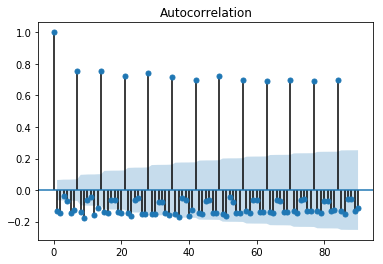

In [119]:
stores = df.Store.unique().tolist()
series = df.loc[df['Store']==stores[np.random.randint(0,len(stores))],'Customers'].values
plot_acf(series,lags=90)
pyplot.show()

# very strong weekly seasonality

In [229]:
## Removing Weekly Seasonality
def remove_lag_seasonality(dataframe, diff_col, new_col_nm, lag, remove_nulls=True):
    dataframe.loc[:,'og_days_prior'] = dataframe.groupby('Store')[diff_col].transform(lambda x:x.shift(lag))
    dataframe.loc[:,new_col_nm] = dataframe.loc[:,diff_col] - dataframe.loc[:,'og_days_prior']
    # remove null values
    if remove_nulls:
        dataframe = dataframe.loc[pd.notnull(dataframe[new_col_nm]),:]
    return dataframe

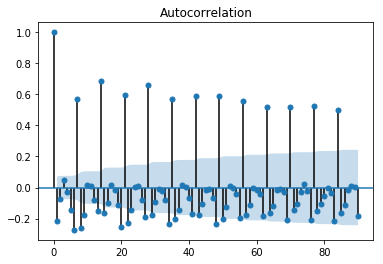

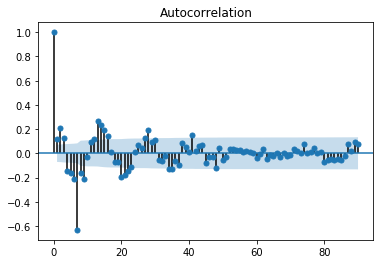

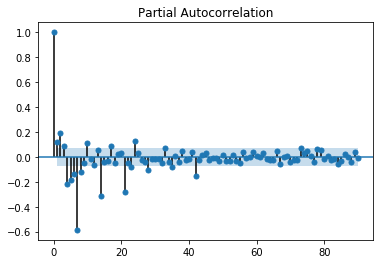

In [230]:
seas_adj = remove_lag_seasonality(df,'Customers','customer_strip_wkly',7)
seas_stores = seas_adj.Store.unique().tolist()
series = (seas_adj.loc[seas_adj['Store']==seas_stores[np.random.randint(0,len(seas_stores))],\
                       ['Date','Customers','customer_strip_wkly']])
# with seasonality
plot_acf(series['Customers'],lags=90)

# without seasonality
plot_acf(series['customer_strip_wkly'],lags=90)

# pacf w/o seas
plot_pacf(series['customer_strip_wkly'],lags=90)
pyplot.show()

In [197]:
series.head()

,Date,Customers,customer_strip_wkly
1008364,2013-01-08,592,592.000
1007249,2013-01-09,540,-75.000
1006134,2013-01-10,579,-17.000
1005019,2013-01-11,641,-7.000
1003904,2013-01-12,571,-51.000


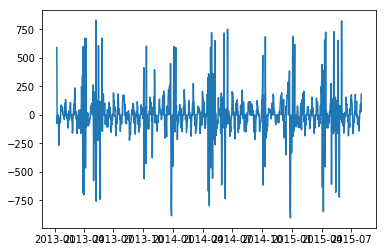

In [215]:
plt.plot(series[['Date','customer_strip_wkly']].set_index('Date'))
pyplot.show()

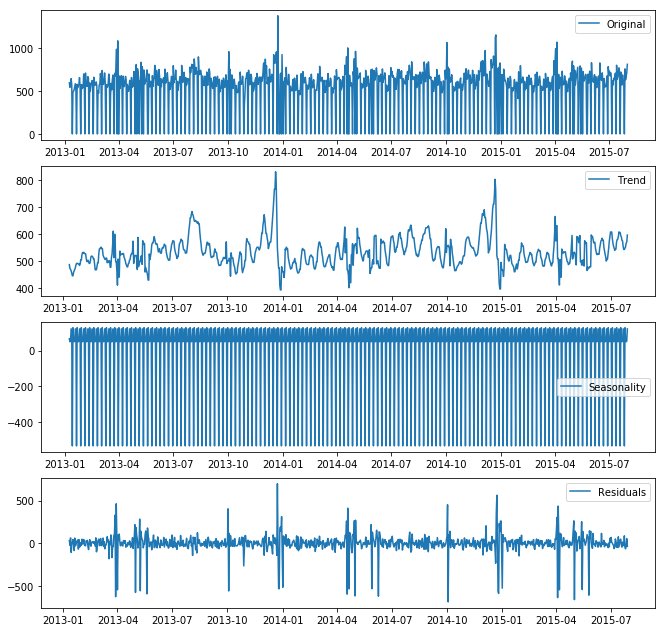

In [218]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series[['Date','Customers']].set_index('Date'))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(11,11))
plt.subplot(411)
plt.plot(series[['Date','Customers']].set_index('Date'), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
# plt.tight_layout()

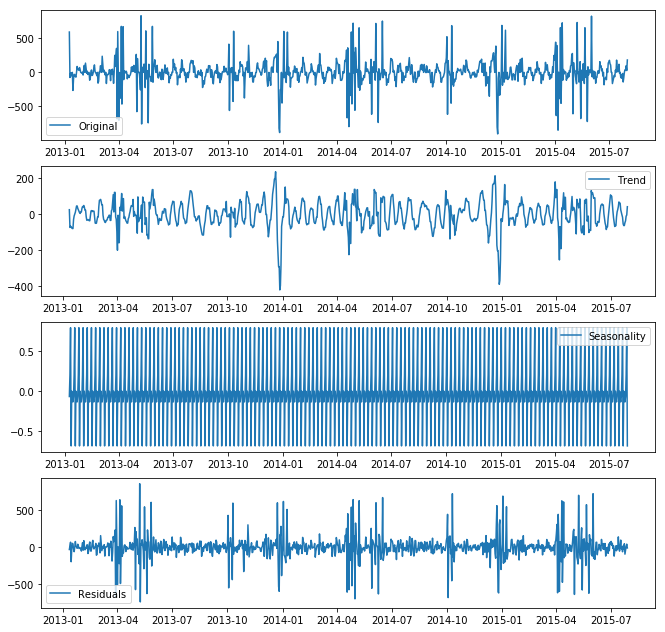

In [219]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series[['Date','customer_strip_wkly']].set_index('Date'))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(11,11))
plt.subplot(411)
plt.plot(series[['Date','customer_strip_wkly']].set_index('Date'), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
# plt.tight_layout()

## Feature Generation (Building in Lags)

In [258]:
def build_feature_lags(dataframe):  
    dataframe = dataframe.sort_values(['Store','Date'])
    for e in np.arange(1,8):
        dataframe.loc[:,'day'+str(e)+'_prior'] = (dataframe.groupby('Store')['customer_strip_wkly']. \
                                                  transform(lambda x:x.shift(e)))
    dataframe.loc[:,'og_days_prior'] = (dataframe.groupby('Store')['Customers']. \
                                                  transform(lambda x:x.shift(7)))
    return(dataframe.loc[pd.notnull(dataframe['day7_prior']),:])

In [240]:
lag_seas_adj = build_feature_lags(seas_adj)

In [244]:
lag_seas_adj.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,day7_prior,customer_strip_wkly,days_prior,day1_prior,day2_prior,day3_prior,day4_prior,day5_prior,day6_prior,og_days_prior
1000485,1,2,2013-01-15,3900,512,1,0,0,0,c,...,654.000,-142.000,654.000,-169.000,0.000,11.000,-27.000,37.000,-42.000,654.000
999370,1,3,2013-01-16,4008,530,1,0,0,0,c,...,-42.000,-96.000,626.000,-142.000,-169.000,0.000,11.000,-27.000,37.000,626.000
998255,1,4,2013-01-17,4044,503,1,0,0,0,c,...,37.000,-112.000,615.000,-96.000,-142.000,-169.000,0.000,11.000,-27.000,615.000
997140,1,5,2013-01-18,4127,568,1,0,0,0,c,...,-27.000,-24.000,592.000,-112.000,-96.000,-142.000,-169.000,0.000,11.000,592.000
996025,1,6,2013-01-19,5182,688,1,0,0,0,c,...,11.000,42.000,646.000,-24.000,-112.000,-96.000,-142.000,-169.000,0.000,646.000


## Start Modeling

In [314]:
# date masks

test_start_date = pd.to_datetime('2015-05-09') # this date leaves 42 days post
valid_start_date = pd.to_datetime('2015-06-20') # this date leaves 42 days post

gbmtrain = lag_seas_adj.loc[lag_seas_adj['Date']<test_start_date,:]
gbmtest = (lag_seas_adj.loc[(lag_seas_adj['Date']>=test_start_date) & 
                          (lag_seas_adj['Date']<valid_start_date),:])
gbmvalid = (lag_seas_adj.loc[lag_seas_adj['Date']>=valid_start_date,:])

In [312]:
param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.02
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
}

# Set up X and Y columns
features = [e for e in gbmtrain]
features.remove('Sales')
features.remove('Customers')
features.remove('open_dt')
features.remove('closed_dt')
features.remove('promo_dt')
features.remove('days_prior')
features.remove('og_days_prior')
response = 'customer_strip_wkly'
y = 'Customers'

In [319]:
# Specify Model
gbm = H2OGradientBoostingEstimator(**param)
gbm.train(x=features, 
          y=y, 
          training_frame=h2o.H2OFrame(gbmtrain), 
          validation_frame=h2o.H2OFrame(gbmtest))

# Summary
gbm

Parse progress: |█████████████████████████████████████████████████████ (failed)  94%


OSError: Job with key $03017f00000132d4ffffffff$_aae09207cef412e46f886fb33e36424e failed with an exception: DistributedException from /127.0.0.1:54321: 'GC overhead limit exceeded', caused by java.lang.OutOfMemoryError: GC overhead limit exceeded
stacktrace: 
DistributedException from /127.0.0.1:54321: 'GC overhead limit exceeded', caused by java.lang.OutOfMemoryError: GC overhead limit exceeded
	at water.MRTask.getResult(MRTask.java:478)
	at water.MRTask.getResult(MRTask.java:486)
	at water.MRTask.doAll(MRTask.java:402)
	at water.parser.ParseDataset.parseAllKeys(ParseDataset.java:257)
	at water.parser.ParseDataset.access$000(ParseDataset.java:29)
	at water.parser.ParseDataset$ParserFJTask.compute2(ParseDataset.java:206)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1395)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.util.Arrays.copyOf(Arrays.java:3308)
	at water.fvec.NewChunk$Mantissas.resize(NewChunk.java:219)
	at water.fvec.NewChunk.append2slow(NewChunk.java:930)
	at water.fvec.NewChunk.addNum(NewChunk.java:565)
	at water.parser.FVecParseWriter.addNumCol(FVecParseWriter.java:135)
	at water.parser.FVecParseWriter.addStrCol(FVecParseWriter.java:166)
	at water.parser.CsvParser.parseChunk(CsvParser.java:165)
	at water.parser.ParseDataset$MultiFileParseTask$DistributedParse.map(ParseDataset.java:978)
	at water.MRTask.compute2(MRTask.java:637)
	at water.H2O$H2OCountedCompleter.compute1(H2O.java:1398)
	at water.parser.ParseDataset$MultiFileParseTask$DistributedParse$Icer.compute1(ParseDataset$MultiFileParseTask$DistributedParse$Icer.java)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1394)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.popAndExecAll(ForkJoinPool.java:904)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:977)
	... 2 more


In [ ]:
prediction = xgb.predict(df_valid)[:,2]

## One Step at a Time Prediction

In [285]:
test_dates

DatetimeIndex(['2015-05-09'], dtype='datetime64[ns]', freq=None)

In [ ]:
= lag_seas_adj.copy()

test_dates = pd.to_datetime(gbmtest['Date'].sort_values().unique()[0:1])
for e in test_dates:
    cp = gbmtest.loc[gbmtest['Date']==e,:].copy()
    cols = ['day7_prior', 'customer_strip_wkly', 'days_prior', 'day1_prior',
           'day2_prior', 'day3_prior', 'day4_prior', 'day5_prior', 'day6_prior',
           'og_days_prior']
    cp.loc[:,cols] = np.NaN
    cp = pd.concat([cp,xgbtrain])
    cp = build_feature_lags(cp)

In [ ]:
cp

In [242]:
lag_seas_adj[['og_days_prior','customer_strip_wkly','Customers','day7_prior','og_days_prior']]

,og_days_prior,customer_strip_wkly,Customers,day7_prior,og_days_prior
1000485,654.000,-142.000,512,654.000,654.000
999370,626.000,-96.000,530,-42.000,626.000
998255,615.000,-112.000,503,37.000,615.000
997140,592.000,-24.000,568,-27.000,592.000
996025,646.000,42.000,688,11.000,646.000
994910,0.000,0.000,0,0.000,0.000
993795,616.000,-9.000,607,-169.000,616.000
992680,512.000,155.000,667,-142.000,512.000
991565,530.000,97.000,627,-96.000,530.000
990450,503.000,142.000,645,-112.000,503.000


In [227]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# h2o.init()

hf = h2o.H2OFrame(seas_adj)

# Set up X and Y columns
X = [e for e in df]
X.remove('Store')
X.remove('Sales')
X.remove('Customers')
X.remove('open_dt')
X.remove('closed_dt')
X.remove('promo_dt')
X.remove('days_prior')
y = 'customer_strip_wkly'

# Split Frame
htrain, hvalid, htest = hf.split_frame([0.6, 0.2], seed=1234)

# Specify Model
gbm = H2OGradientBoostingEstimator(seed=123)
gbm.train(X, y, training_frame=htrain, validation_frame=hvalid)

# Summary
gbm

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551600840383_6


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 11929.369348605942
RMSE: 109.22165237994682
MAE: 64.4422756487986
RMSLE: NaN
Mean Residual Deviance: 11929.369348605942

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 11926.770496530771
RMSE: 109.20975458506796
MAE: 64.63841567727748
RMSLE: NaN
Mean Residual Deviance: 11926.770496530771
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-03 12:30:19,0.001 sec,0.0,265.0406023,154.4158407,70246.5208577,263.6260821,154.7125738,69498.7111410
,2019-03-03 12:30:19,0.641 sec,1.0,258.0717936,152.5888432,66601.0506444,256.5618650,152.8468922,65823.9905964
,2019-03-03 12:30:20,1.184 sec,2.0,252.2718559,150.9676188,63641.0892833,250.7212892,151.1953396,62861.1648527
,2019-03-03 12:30:21,1.694 sec,3.0,240.9055212,147.2332780,58035.4701511,239.4747553,147.4374087,57348.1584318
,2019-03-03 12:30:21,2.290 sec,4.0,228.0763843,139.4277486,52018.8370755,226.6923971,139.6256127,51389.4428974
,2019-03-03 12:30:22,2.998 sec,5.0,214.0034532,130.1106432,45797.4779962,212.6861171,130.3007070,45235.3843959
,2019-03-03 12:30:22,3.600 sec,6.0,201.5855756,121.6036765,40636.7442758,200.2965649,121.7764906,40118.7139014
,2019-03-03 12:30:27,7.877 sec,15.0,142.9015199,84.0813207,20420.8443888,142.1826398,84.1978800,20215.9030698
,2019-03-03 12:30:33,14.504 sec,19.0,131.9491388,77.3983864,17410.5752266,131.3268589,77.5208923,17246.7438603
,2019-03-03 12:30:45,26.404 sec,38.0,113.1353810,66.5354685,12799.6144253,112.8984122,66.7068016,12746.0514845


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
day7_prior,88894185472.0000000,1.0,0.4780284
StateHoliday,29457508352.0000000,0.3313772,0.1584077
Open,24376041472.0000000,0.2742141,0.1310821
Promo,14474411008.0000000,0.1628274,0.0778361
day6_prior,7969991680.0000000,0.0896571,0.0428586
---,---,---,---
CompetitionOpenSinceMonth,14698696.0000000,0.0001654,0.0000790
Assortment,12568078.0000000,0.0001414,0.0000676
CompetitionOpenSinceYear,3510449.7500000,0.0000395,0.0000189
Promo2,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [289]:
train['Customers'].median()

609.0

In [243]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# h2o.init()

hf = h2o.H2OFrame(seas_adj)

# Set up X and Y columns
X = [e for e in df]
# X.remove('Store')
X.remove('Sales')
X.remove('Customers')
X.remove('open_dt')
X.remove('closed_dt')
X.remove('promo_dt')
X.remove('days_prior')
y = 'customer_strip_wkly'

# Split Frame
htrain, hvalid, htest = hf.split_frame([0.6, 0.2], seed=1234)

# Specify Model
gbm = H2OGradientBoostingEstimator(seed=123)
gbm.train(X, y, training_frame=htrain, validation_frame=hvalid)

# Summary
gbm

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1551600840383_7


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 9575.49995230786
RMSE: 97.85448355751443
MAE: 58.6591011310375
RMSLE: NaN
Mean Residual Deviance: 9575.49995230786

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 9513.997771859867
RMSE: 97.5397240710669
MAE: 58.8343030623359
RMSLE: NaN
Mean Residual Deviance: 9513.997771859867
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-03 12:43:15,0.003 sec,0.0,265.0406023,154.4158407,70246.5208577,263.6260821,154.7125738,69498.7111410
,2019-03-03 12:43:16,0.850 sec,1.0,257.3607138,152.5578551,66234.5370257,255.8639364,152.8225836,65466.3539462
,2019-03-03 12:43:17,1.218 sec,2.0,250.9584553,150.9093677,62980.1463017,249.3864569,151.1403888,62193.6048771
,2019-03-03 12:43:17,2.147 sec,3.0,238.8434967,147.0455544,57046.2158976,237.2795776,147.2361251,56301.5979598
,2019-03-03 12:43:18,2.625 sec,4.0,225.0114589,138.8855365,50630.1566433,223.4675318,139.0697775,49937.7377490
,2019-03-03 12:43:19,3.373 sec,5.0,210.1865700,129.4963934,44178.3942126,208.7437559,129.6817816,43573.9556094
,2019-03-03 12:43:23,7.879 sec,13.0,143.7043928,87.6417096,20650.9525007,142.5216518,87.7230170,20312.4212359
,2019-03-03 12:43:28,12.274 sec,20.0,118.9697015,72.1771038,14153.7898825,118.0397663,72.2319630,13933.3864166
,2019-03-03 12:43:32,16.710 sec,27.0,108.2358343,65.0832820,11714.9958257,107.4891491,65.1761317,11553.9171734
,2019-03-03 12:43:36,20.782 sec,35.0,102.5149344,61.3896973,10509.3117698,101.8719181,61.5198382,10377.8877018


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
day7_prior,75718565888.0000000,1.0,0.3913669
StateHoliday,30587695104.0000000,0.4039656,0.1580988
og_days_prior,30124113920.0000000,0.3978432,0.1557027
Open,25816154112.0000000,0.3409488,0.1334361
Promo,15228959744.0000000,0.2011258,0.0787140
---,---,---,---
CompetitionOpenSinceYear,10085797.0000000,0.0001332,0.0000521
CompetitionOpenSinceMonth,1966296.1250000,0.0000260,0.0000102
Promo2,0.0,0.0,0.0
Promo2SinceYear,0.0,0.0,0.0



See the whole table with table.as_data_frame()


## XGBoost Model Portion

In [ ]:
# so, we have something that can predict the next step.
# we want to then incorporate that next step into the next prediction and then keep predicting for the entirety of the time series


In [ ]:
# split pdf into train and test
X = pdf_final

# y = pdf_final['next_mon_pcxl']
y = pdf_final['next_3mon_pcxl']

# create an nfold column based on dealer_location_ids
groups = pdf_final['f_cdd_dealership_id']

# create train / valid set
train_inds, test_inds = next(sklearn.model_selection.GroupShuffleSplit(n_splits=5,test_size=0.2,random_state=42).split(pdf_final, groups=groups))

# create train / valid set
train, valid = pdf_final.iloc[train_inds], pdf_final.iloc[test_inds]

# create xvalidation set
xval_groups = train['f_cdd_dealership_id']
gkf = sklearn.model_selection.GroupKFold(n_splits=5)

#create fold_column in train set.
group_ct = 1

fold_index=pd.DataFrame()

for train_index, test_index in gkf.split(train,groups=xval_groups):
    t = pd.DataFrame(test_index)
    t['fold_column']=group_ct
    fold_index = pd.concat([fold_index,t])
    group_ct+=1
    
train['fold_column']=fold_index.sort_values(0)['fold_column'].values

param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.02
    , "sample_rate" : 0.7
    , "col_sample_rate_per_tree" : 0.9
    , "min_rows" : 5
    , "seed": 4241
    , "score_tree_interval": 100
}
from h2o.estimators import H2OXGBoostEstimator
model = H2OXGBoostEstimator(**param)

# Please Don't Go Further

## First Model (LSTM)

First, let's try use Seq2Seq in order to see if this is a good way of forecasting. I am following this tutorial: https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb

In [ ]:
train.head(3)

In [ ]:
train.columns[1]

In [ ]:
data_start_date = train.columns[1]
data_end_date = train.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

In [ ]:
def plot_random_series(train, n_series):
    
    sample = train.sample(n_series, random_state=8)
    page_labels = sample['Store'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        pd.Series(series_samples.iloc[i]).astype(np.float64).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Daily Store Sales')
    plt.legend(page_labels)
    
plot_random_series(train, 3)

In [ ]:
from datetime import timedelta

pred_steps = 14
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

In [ ]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in train.columns[1:]]),
                          data=[i for i in range(len(train.columns[1:]))])

series_array = train[train.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM

# convolutional layer parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)]

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':14})(x)

model = Model(history_seq, pred_seq_train)

model.summary()

In [ ]:
first_n_samples = 1000
batch_size = 128
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# okay, so for each one of these, 
# 1) for the encoder portion, we first take each series and subtract the mean
# 2) for the decoder portion, we find the prediction (last 2 weeks) and then set that up with the same transformations

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

# here, we are adding the lagged history of the target series to the input data at the end
# looks like, train then test-1 day


In [ ]:
model.compile(Adam(), loss='mean_absolute_percentage_error')
history = model.fit(encoder_input_data, 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [ ]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [ ]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
encode_series_mean[0:1]

In [ ]:
def predict_and_plot(encoder_input_data, encode_series_mean, decoder_target_data, sample_ind, enc_tail_len=14):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    encode_series_mean = encode_series_mean[sample_ind:sample_ind+1] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    encode_series += encode_series_mean
    pred_series = pred_series.reshape(-1,1)
    pred_series += encode_series_mean
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    target_series += encode_series_mean
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [ ]:
predict_and_plot(encoder_input_data, encode_series_mean, decoder_target_data,0)

issues with install: https://forums.fast.ai/t/fastai-v0-7-install-issues-thread/24652 

## Try version with actual LSTM

https://github.com/jfpuget/Kaggle/blob/master/WebTrafficPrediction/keras_simple.ipynb